In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

import sys
import copy
sys.path.append("../../")

import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [2]:
models = torch.load("model/gradvsODEvsFD_new.pt")
lagODE_model = torch.load("model/gradvsODEvsFD_lagODE_new.pt")
models.insert(1, lagODE_model )

for model in models:
    model.eval()
None

In [3]:
# pole_lagODE_model = torch.load("model/test.pt")

In [4]:
len(models)

12

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for model in models:
    print("{} have {} parameters".format(type(model), count_parameters(model)))

<class 'torchdyn.core.neuralde.NeuralODE'> have 5666 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 5666 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 5657 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 5664 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 5666 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 5666 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 5657 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 5664 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 5666 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 5666 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 5657 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 5664 parameters


In [6]:
test_set = torch.load('data/Pendulum_test_set_new.pt')
training_set = torch.load('data/Pendulum_training_set_new.pt')

In [7]:
print(test_set.tensors[0].shape)
print(training_set.tensors[0].shape)

torch.Size([100, 200, 3])
torch.Size([1000, 7, 3])


### Get test err

In [8]:
from utils import traj_pred

In [9]:
test_traj = torch.cat([test_set.tensors[0], test_set.tensors[1]], dim=2)
train_traj = torch.cat([training_set.tensors[0], training_set.tensors[1]], dim=2)[:300, :, :]

In [10]:
print(test_traj.shape)
print(test_set.tensors[0].shape)
print(train_traj.shape)

torch.Size([100, 200, 4])
torch.Size([100, 200, 3])
torch.Size([300, 7, 4])


(3, 200)
torch.Size([200, 1])


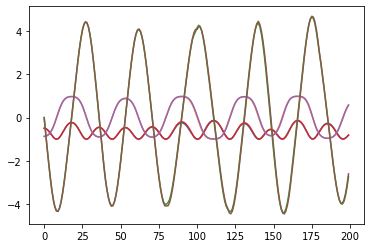

In [11]:
start = 0
end = 300
idx = 34
est_traj = traj_pred(0.05, models[2], test_traj[idx, 0, :3], test_traj[idx, :, [3]])
print(est_traj.y.shape)
print(test_traj[idx, :, [3]].shape)
plt.plot(est_traj.y.T[start:end, :])
plt.plot(test_traj[idx, start:end, :3])

In [12]:
test_err = []
train_err = []

t_span1 = test_set.tensors[2][0, :, -1]
t_span2 = training_set.tensors[2][0, :, -1]

test_traj = torch.cat([test_set.tensors[0], test_set.tensors[1]], dim=2)
train_traj = torch.cat([training_set.tensors[0], training_set.tensors[1]], dim=2)[:300, :, :]

for i, model in enumerate(models):
    # Generate estimated trajectory
    print("cur model {}".format(i))
    est_trajs1 = []
    for traj_idx in range(test_traj.shape[0]):
        if traj_idx % 10 == 0:
            print("test traj {}".format(traj_idx))
        est_traj1 = traj_pred(0.05, models[i], test_traj[traj_idx, 0, :3], test_traj[traj_idx, :, [3]])
        est_trajs1.append(est_traj1.y.T)
        
    est_trajs1 = torch.tensor(est_trajs1)
        
    est_trajs2 = []
    for traj_idx in range(train_traj.shape[0]):
        if traj_idx % 100 == 0:
            print("train {}".format(traj_idx))
        est_traj2 = traj_pred(0.05, models[i], train_traj[traj_idx, 0, :3], train_traj[traj_idx, :, [3]])
        est_trajs2.append(est_traj2.y.T)
        
    est_trajs2 = torch.tensor(est_trajs2)

    loss_test = torch.nn.functional.mse_loss(est_trajs1, test_set.tensors[0]).detach()
    loss_train = torch.nn.functional.mse_loss(est_trajs2, training_set.tensors[0][:300, :, :]).detach()
    
    test_err.append(loss_test)
    train_err.append(loss_train)

cur model 0
test traj 0
test traj 10
test traj 20
test traj 30
test traj 40
test traj 50
test traj 60
test traj 70
test traj 80
test traj 90
train 0
train 100
train 200
cur model 1
test traj 0
test traj 10
test traj 20
test traj 30
test traj 40
test traj 50
test traj 60
test traj 70
test traj 80
test traj 90
train 0
train 100
train 200
cur model 2
test traj 0
test traj 10
test traj 20
test traj 30
test traj 40
test traj 50
test traj 60
test traj 70
test traj 80
test traj 90
train 0
train 100
train 200
cur model 3
test traj 0
test traj 10
test traj 20
test traj 30
test traj 40
test traj 50
test traj 60
test traj 70
test traj 80
test traj 90
train 0
train 100
train 200
cur model 4
test traj 0
test traj 10
test traj 20
test traj 30
test traj 40
test traj 50
test traj 60
test traj 70
test traj 80
test traj 90
train 0
train 100
train 200
cur model 5
test traj 0
test traj 10
test traj 20
test traj 30
test traj 40
test traj 50
test traj 60
test traj 70
test traj 80
test traj 90
train 0
train 

In [13]:
model_name = ['hamODE', 'lagODE', 'symODE', 'baselineODE',
              'hamODE_grad', 'lagODE_grad', 'symODE_grad', 'baselineODE_grad',
              'hamODE_fd', 'lagODE_fd', 'symODE_fd', 'baselineODE_fd']

for i in range(len(test_err)):
    print(i, model_name[i], test_err[i], train_err[i])

0 hamODE tensor(2.4807, dtype=torch.float64) tensor(4.8152e-05, dtype=torch.float64)
1 lagODE tensor(5.1841, dtype=torch.float64) tensor(9.5197e-05, dtype=torch.float64)
2 symODE tensor(0.6018, dtype=torch.float64) tensor(5.6831e-06, dtype=torch.float64)
3 baselineODE tensor(3.7555, dtype=torch.float64) tensor(2.5849e-05, dtype=torch.float64)
4 hamODE_grad tensor(1.1692, dtype=torch.float64) tensor(6.8857e-06, dtype=torch.float64)
5 lagODE_grad tensor(1.0349, dtype=torch.float64) tensor(3.4553e-05, dtype=torch.float64)
6 symODE_grad tensor(0.6358, dtype=torch.float64) tensor(4.3602e-06, dtype=torch.float64)
7 baselineODE_grad tensor(1.5821, dtype=torch.float64) tensor(3.6388e-05, dtype=torch.float64)
8 hamODE_fd tensor(2.4945, dtype=torch.float64) tensor(0.0035, dtype=torch.float64)
9 lagODE_fd tensor(1.8783, dtype=torch.float64) tensor(0.0009, dtype=torch.float64)
10 symODE_fd tensor(1.4214, dtype=torch.float64) tensor(0.0008, dtype=torch.float64)
11 baselineODE_fd tensor(6.4095, dtyp

Epoch 3790
--- 452.1320581436157 seconds ---

Epoch 457:
--- 107.33525609970093 seconds ---

Epoch 1808
--- 788.8814210891724 seconds ---

Epoch 1565
--- 128.19660806655884 seconds ---

Epoch 5938
--- 302.39898896217346 seconds ---

Epoch 2298
--- 125.25190305709839 seconds ---

Epoch 1725
--- 102.18103218078613 seconds ---

Epoch 1530
--- 33.727455854415894 seconds ---

Epoch 2914
--- 81.02679991722107 seconds ---

Epoch 1592
--- 69.32706904411316 seconds ---

Epoch 247
--- 14.343279838562012 seconds ---

Epoch 1755
--- 40.801060914993286 seconds ---


### Trajectory Test

In [14]:
from gym_env import PendulumCustomEnv

In [15]:
# define testing time stamp
dt = 0.05
full = 1000
t_span = torch.linspace(dt, dt*full, full)

In [16]:
# Generate Trajectory
def generate_traj(x0=1.5, dx0=1.5, t0=0, steps=200):
    env = PendulumCustomEnv()
    env.seed(0)
    np.random.seed(0)
#     np.random.seed(1)
    obs = []
    infos = []

    split = 20
    controls = np.random.uniform(-2, 2, int(steps / split))
    controls = np.repeat(controls, split)
    controls = torch.tensor(controls)
    obs0, _ = env.reset(np.array([x0, dx0]))

    prev_obs = obs0
    for i in range(steps):
        obs.append(prev_obs)

        next_obs, reward, done, info = env.step(controls[i])
        infos.append(np.array([info['th'], info['dth'], info['ddth']]))
        prev_obs = next_obs
    
    obs = torch.tensor(obs)
    infos = torch.tensor(infos)

    return obs.float(), infos.float(), controls.view(-1, 1).float()

In [17]:
# Generate Trajectory from true model
t0 = 0
dt = 0.05
steps = 200
t1 = steps * dt

traj1_true, infos1, controls1 = generate_traj(x0=2, dx0=-2, t0=t0, steps=steps)
traj2_true, infos2, controls2 = generate_traj(x0=1, dx0=-1, t0=t0, steps=steps)

# Generate Estimated Trajectory
t_span = torch.linspace(t0, t1, steps)
trajs1 = []
trajs2 = []

for model in models:
    print("finished 1 traj")
    traj1 = traj_pred(0.05, model, traj1_true[0, :3], controls1).y.T
    traj2 = traj_pred(0.05, model, traj2_true[0, :3], controls2).y.T
    
    trajs1.append(traj1)
    trajs2.append(traj2)

finished 1 traj
finished 1 traj
finished 1 traj
finished 1 traj
finished 1 traj
finished 1 traj
finished 1 traj
finished 1 traj
finished 1 traj
finished 1 traj
finished 1 traj
finished 1 traj


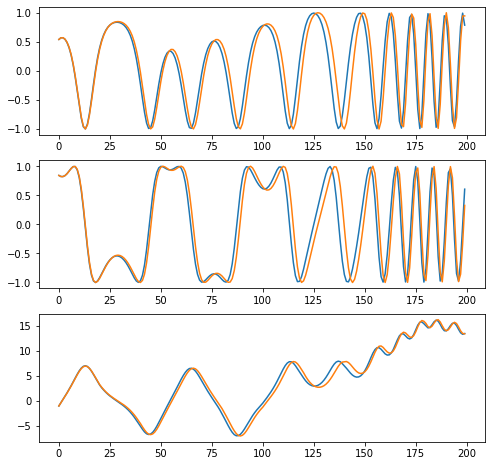

In [18]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

length = 200
model_idx = 2

ax1.plot(trajs2[model_idx][:length, 0])
ax1.plot(traj2_true[:length, 0])

ax2.plot(trajs2[model_idx][:length, 1])
ax2.plot(traj2_true[:length, 1])

ax3.plot(trajs2[model_idx][:length, 2])
ax3.plot(traj2_true[:length, 2])

In [19]:
# Recover theta
trajs1_recover = []
trajs2_recover = []
with torch.no_grad():
    for traj_idx in range(len(trajs1)):
        angle1 = np.arctan2(trajs1[traj_idx][:, 1], trajs1[traj_idx][:, 0])
        angle2 = np.arctan2(trajs2[traj_idx][:, 1], trajs2[traj_idx][:, 0])
        
        angle1 = np.unwrap(angle1)
        angle2 = np.unwrap(angle2)
        
        th_dth1 = torch.stack([torch.tensor(angle1), torch.tensor(trajs1[traj_idx][:, 2])], dim=1)
        th_dth2 = torch.stack([torch.tensor(angle2), torch.tensor(trajs2[traj_idx][:, 2])], dim=1)
            
        trajs1_recover.append(th_dth1)
        trajs2_recover.append(th_dth2)

Text(0, 0.5, 'dq')

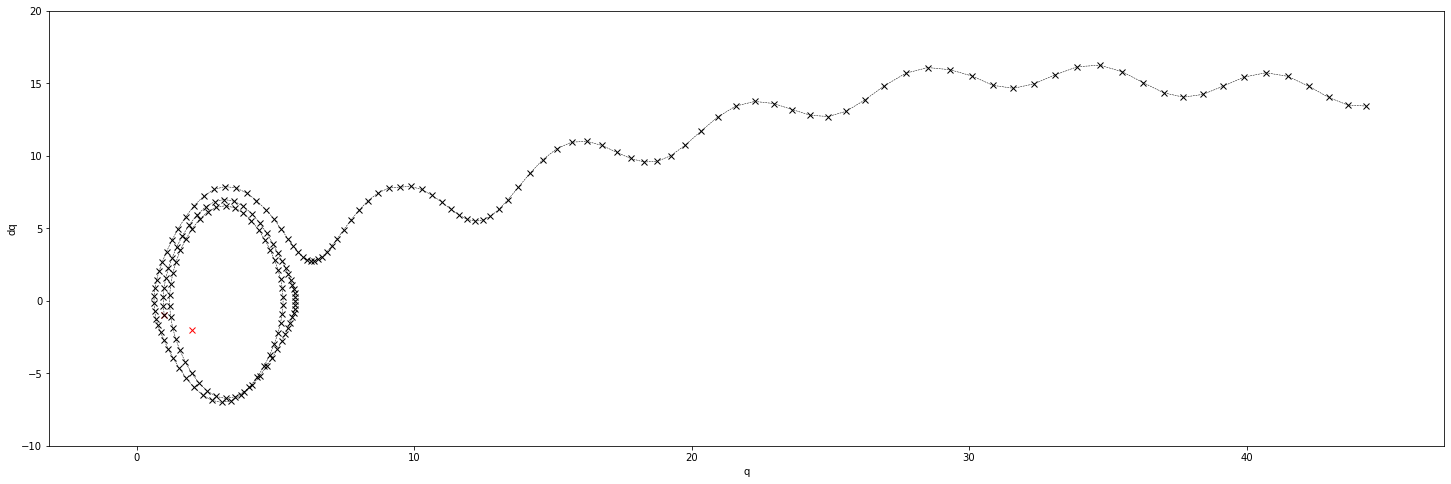

In [20]:
fig = plt.figure(figsize=(25,8))
ax = fig.add_subplot(111)

length = 200
model_idx = 2

ax.plot(infos1[0, 0], infos1[0, 1], marker='x', color="red")  # init pos
ax.plot(infos2[0, 0], infos2[0, 1], marker='x', color="red")  # init pos


# ax.plot(trajs1_recover[model_idx][:length, 0], trajs1_recover[model_idx][:length, 1], 'b--')
# ax.plot(np.unwrap(infos1[:length, 0]), infos1[:length, 1],
#         color='black', alpha=1, label='ground truth', linewidth=0.5)

ax.plot(np.unwrap(infos2[:length, 0]), infos2[:length, 1], 'x--',
        color='black', alpha=1, linewidth=0.5)

ax.set_xlim([-np.pi, 15*np.pi])
ax.set_ylim([-10, 20])
ax.set_xlabel("q")
ax.set_ylabel("dq")
# ax.legend(loc='lower right')
    

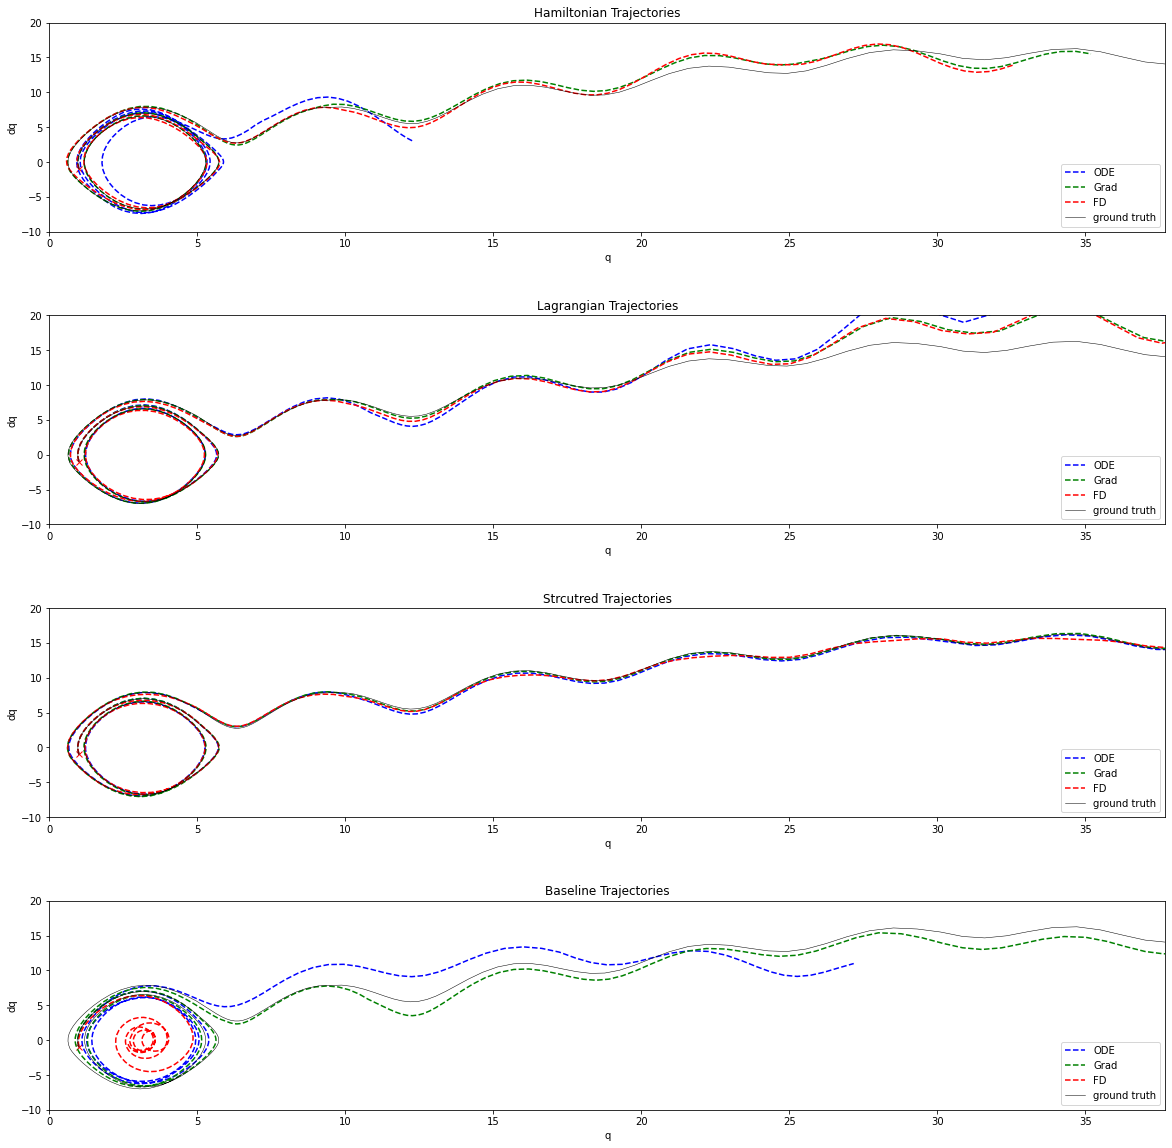

In [36]:
# Plot the trajectory generated from the model
# Phase Plot
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)

ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

axs = [ax1, ax2, ax3, ax4]

length = 200
for idx, ax in enumerate(axs):

    ax.plot(infos2[0, 0], infos2[0, 1], marker='x', color="red")  # init pos

    ax.plot(trajs2_recover[idx][:length, 0], trajs2_recover[idx][:length, 1], 'b--', label='ODE')
    ax.plot(trajs2_recover[idx+4][:length, 0], trajs2_recover[idx+4][:length, 1], 'g--', label='Grad')
    ax.plot(trajs2_recover[idx+8][:length, 0], trajs2_recover[idx+8][:length, 1], 'r--', label='FD')
    ax.plot(np.unwrap(infos2[:length, 0]), infos2[:length, 1],
            color='black', alpha=1, label='ground truth', linewidth=0.5)

    ax.set_xlim([0, 12 * np.pi])
    ax.set_ylim([-10, 20])
    ax.set_xlabel("q")
    ax.set_ylabel("dq")
    ax.legend(loc='lower right')
    
ax1.set_title("Hamiltonian Trajectories")
ax2.set_title("Lagrangian Trajectories")
ax3.set_title("Strcutred Trajectories")
ax4.set_title("Baseline Trajectories")

None

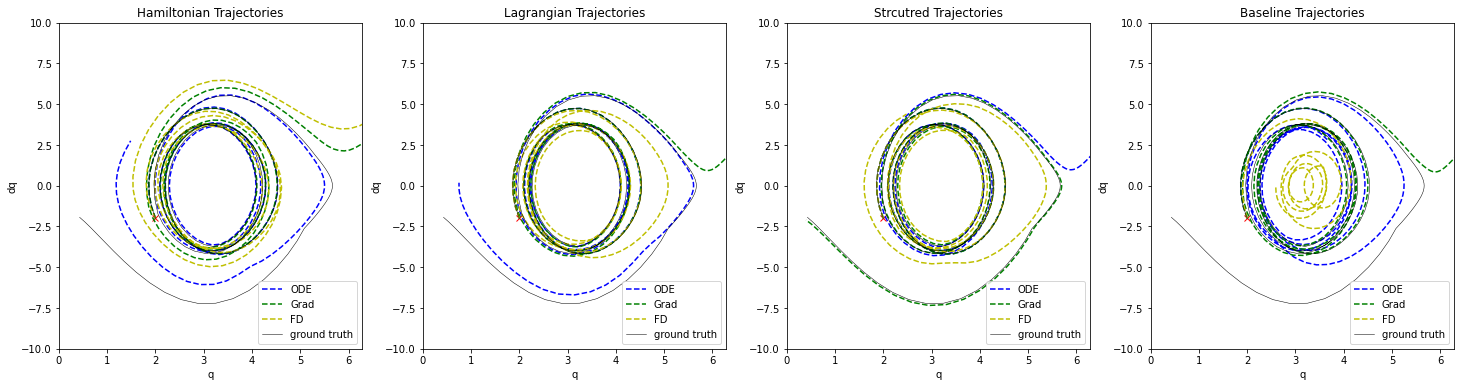

In [37]:
# Plot the trajectory generated from the model
# Phase Plot
fig = plt.figure(figsize=(25, 6))
plt.subplots_adjust(hspace=0.4)

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

axs = [ax1, ax2, ax3, ax4]

length = 200
for idx, ax in enumerate(axs):
    ax.plot(infos1[0, 0], infos1[0, 1], marker='x', color="red")  # init pos

    ax.plot(trajs1_recover[idx][:length, 0], trajs1_recover[idx][:length, 1], 'b--', label='ODE')
    ax.plot(trajs1_recover[idx+4][:length, 0], trajs1_recover[idx+4][:length, 1], 'g--', label='Grad')
    ax.plot(trajs1_recover[idx+8][:length, 0], trajs1_recover[idx+8][:length, 1], 'y--', label='FD')
    ax.plot(np.unwrap(infos1[:length, 0]), infos1[:length, 1],
            color='black', alpha=1, label='ground truth', linewidth=0.5)
    
    ax.set_xlim([0., 2 * np.pi])
    ax.set_ylim([-10, 10])
    ax.set_xlabel("q")
    ax.set_ylabel("dq")
    ax.legend(loc='lower right')
    
ax1.set_title("Hamiltonian Trajectories")
ax2.set_title("Lagrangian Trajectories")
ax3.set_title("Strcutred Trajectories")
ax4.set_title("Baseline Trajectories")

None

### Estimated Traj

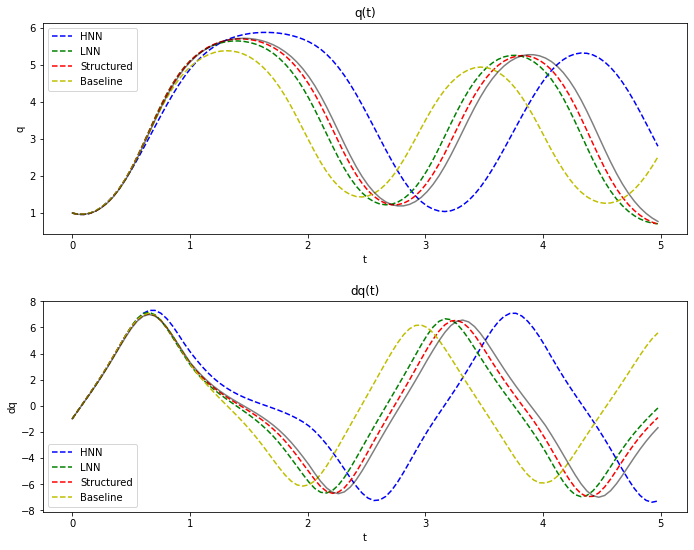

In [23]:
# Plot q(t) and p(t) graph
start = 0
end = 100
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)

ax1.plot(t_span[start:end], trajs2_recover[0][start:end, 0], 'b--', label='HNN')
ax1.plot(t_span[start:end], trajs2_recover[1][start:end, 0], 'g--', label='LNN')
ax1.plot(t_span[start:end], trajs2_recover[2][start:end, 0], 'r--', label='Structured')
ax1.plot(t_span[start:end], trajs2_recover[3][start:end, 0], 'y--', label='Baseline')

ax1.plot(t_span[start:end], np.unwrap(infos2[start:end, 0]), color='black', alpha=0.5)  # traj

ax1.set_xlabel("t")
ax1.set_ylabel("q")
ax1.set_title("q(t)")

ax2 = fig.add_subplot(212)
ax2.plot(t_span[start:end], trajs2_recover[0][start:end, 1], 'b--', label='HNN')
ax2.plot(t_span[start:end], trajs2_recover[1][start:end, 1], 'g--', label='LNN')
ax2.plot(t_span[start:end], trajs2_recover[2][start:end, 1], 'r--', label='Structured')
ax2.plot(t_span[start:end], trajs2_recover[3][start:end, 1], 'y--', label='Baseline')

ax2.plot(t_span[start:end], infos2[start:end, 1], color='black', alpha=0.5)  # traj

ax2.set_xlabel("t")
ax2.set_ylabel("dq")
ax2.set_title("dq(t)")

ax1.legend()
ax2.legend()
fig.tight_layout(pad=2.0)
None

### Estimated Force

In [24]:
ddq1 = []
ddq2 = []
for idx, model in enumerate(models):
    q_dq_u1 = torch.cat([torch.tensor(traj1_true), controls1], dim=1)
    est_grad1 = model.defunc(0, q_dq_u1.float()).detach()
    ddq1.append(est_grad1)
    q_dq_u2 = torch.cat([torch.tensor(traj2_true), controls2], dim=1)
    est_grad2 = model.defunc(0, q_dq_u2.float()).detach()
    ddq2.append(est_grad2)

<ipython-input-24-057433590515>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_dq_u1 = torch.cat([torch.tensor(traj1_true), controls1], dim=1)
<ipython-input-24-057433590515>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_dq_u2 = torch.cat([torch.tensor(traj2_true), controls2], dim=1)


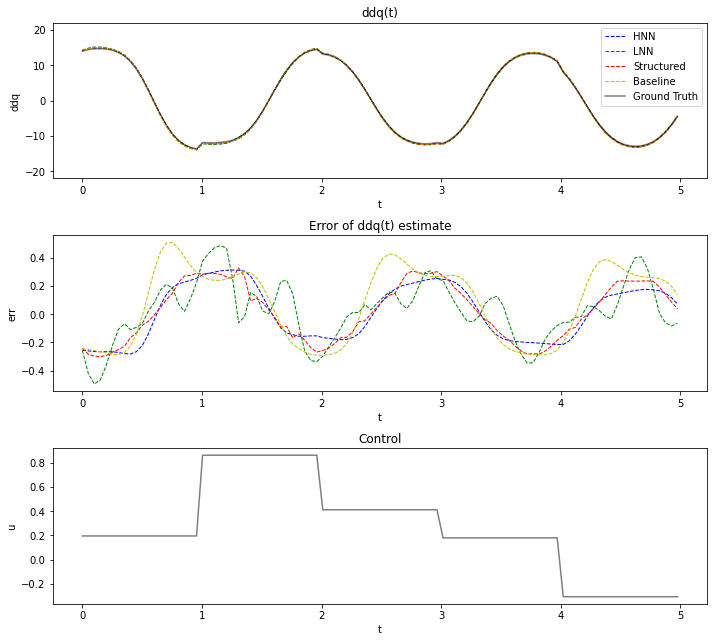

In [43]:
# Plot q(t) and p(t) graph
start = 0
end = 100
fig = plt.figure(figsize=(10, 9))
ax1 = fig.add_subplot(311)

ax1.plot(t_span[start:end], ddq1[0][start:end, 2], 'b--', label='HNN', linewidth=1)
ax1.plot(t_span[start:end], ddq1[1][start:end, 2], 'g--', label='LNN', linewidth=1)
ax1.plot(t_span[start:end], ddq1[2][start:end, 2], 'r--', label='Structured', linewidth=1)
ax1.plot(t_span[start:end], ddq1[3][start:end, 2], 'y--', label='Baseline', linewidth=1)

ax1.plot(t_span[start:end], infos1[start:end, 2], color='black', alpha=0.5, label="Ground Truth")  # traj

ax1.set_xlabel("t")
ax1.set_ylabel("ddq")
ax1.set_title("ddq(t)")

ax2 = fig.add_subplot(312)

ax2.plot(t_span[start:end], infos1[start:end, 2] - ddq1[0][start:end, 2], 'b--', label='HNN', linewidth=1)
ax2.plot(t_span[start:end], infos1[start:end, 2] - ddq1[1][start:end, 2], 'g--', label='LNN', linewidth=1)
ax2.plot(t_span[start:end], infos1[start:end, 2] - ddq1[2][start:end, 2], 'r--', label='Structured', linewidth=1)
ax2.plot(t_span[start:end], infos1[start:end, 2] - ddq1[3][start:end, 2], 'y--', label='Baseline', linewidth=1)

ax2.set_xlabel("t")
ax2.set_ylabel("err")
ax2.set_title("Error of ddq(t) estimate")

ax3 = fig.add_subplot(313)
ax3.plot(t_span[start:end], controls1[start:end, 0], color='black', alpha=0.5)  # traj

ax3.set_xlabel("t")
ax3.set_ylabel("u")
ax3.set_title("Control")

ax1.legend()
ax1.set_ylim([-22, 22])
fig.tight_layout(pad=1.0)
None

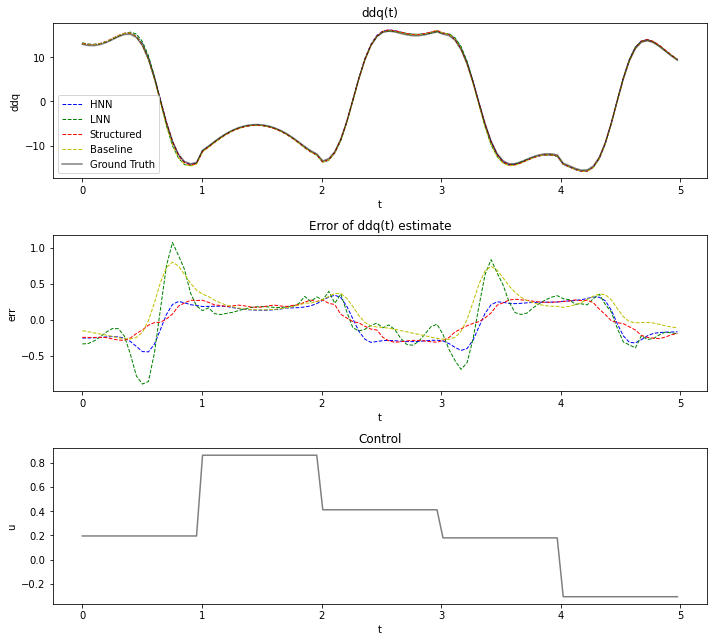

In [47]:
start = 0
end = 100
fig = plt.figure(figsize=(10, 9))
ax1 = fig.add_subplot(311)

ax1.plot(t_span[start:end], ddq2[0][start:end, 2], 'b--', label='HNN', linewidth=1)
ax1.plot(t_span[start:end], ddq2[1][start:end, 2], 'g--', label='LNN', linewidth=1)
ax1.plot(t_span[start:end], ddq2[2][start:end, 2], 'r--', label='Structured', linewidth=1)
ax1.plot(t_span[start:end], ddq2[3][start:end, 2], 'y--', label='Baseline', linewidth=1)

ax1.plot(t_span[start:end], infos2[start:end, 2], color='black', alpha=0.5, label="Ground Truth")  # traj

ax1.set_xlabel("t")
ax1.set_ylabel("ddq")
ax1.set_title("ddq(t)")

ax2 = fig.add_subplot(312)

ax2.plot(t_span[start:end], infos2[start:end, 2] - ddq2[0][start:end, 2], 'b--', label='HNN', linewidth=1)
ax2.plot(t_span[start:end], infos2[start:end, 2] - ddq2[1][start:end, 2], 'g--', label='LNN', linewidth=1)
ax2.plot(t_span[start:end], infos2[start:end, 2] - ddq2[2][start:end, 2], 'r--', label='Structured', linewidth=1)
ax2.plot(t_span[start:end], infos2[start:end, 2] - ddq2[3][start:end, 2], 'y--', label='Baseline', linewidth=1)

ax2.set_xlabel("t")
ax2.set_ylabel("err")
ax2.set_title("Error of ddq(t) estimate")

ax3 = fig.add_subplot(313)
ax3.plot(t_span[start:end], controls2[start:end, 0], color='black', alpha=0.5)  # traj

ax3.set_xlabel("t")
ax3.set_ylabel("u")
ax3.set_title("Control")

ax1.legend()
# ax1.set_ylim([-22, 22])
fig.tight_layout(pad=1.0)
None

In [71]:
test_model = models[3]

In [72]:
with torch.no_grad():
    n_grid = 100
    x = torch.linspace(-2 * np.pi, 2 * np.pi, n_grid)
    y = torch.linspace(-10, 10, n_grid)
    Q, dQ = torch.meshgrid(x, y)  # all (q, p)

    L, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)

    for i in range(n_grid):
        for j in range(n_grid):
            x = torch.cat([torch.cos(Q[i, j].reshape(1, 1)),
                           torch.sin(Q[i, j].reshape(1, 1)),
                           dQ[i, j].reshape(1, 1)], 1)
            x_u = torch.cat([x, torch.zeros(1, 1)], dim=1)
            
            # L[i, j] = test_model.defunc.m.L(x)
            grad = test_model.defunc(0, x_u).detach().cpu()
            # U[i, j], V[i, j] = -grad[:, 0]/torch.sin(Q[i, j].reshape(1, 1)), grad[:, 2]
            U[i, j], V[i, j] = grad[:, 1]/torch.cos(Q[i, j].reshape(1, 1)), grad[:, 2]

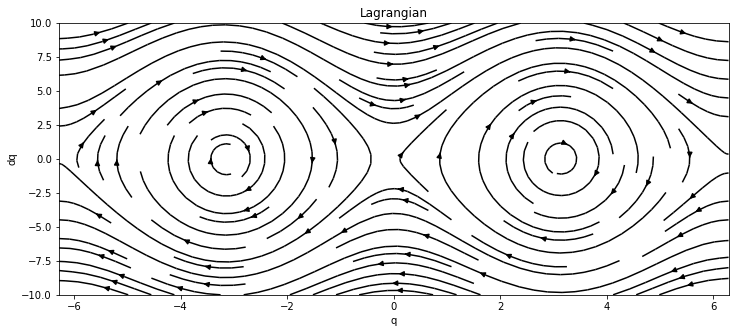

In [73]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
# CS = ax.contourf(Q, dQ, L, 100, cmap='RdYlBu')
# fig.colorbar(CS)

# ax.streamplot(Q.T.numpy(), dQ.T.numpy(), U.T.numpy(), V.T.numpy(), color='black')
ax.streamplot(Q.T.numpy(), dQ.T.numpy(), U.T.numpy(), V.T.numpy(), color='black')

ax.set_xlim([Q.min(), Q.max()])
ax.set_ylim([dQ.min(), dQ.max()])
ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Lagrangian")
None

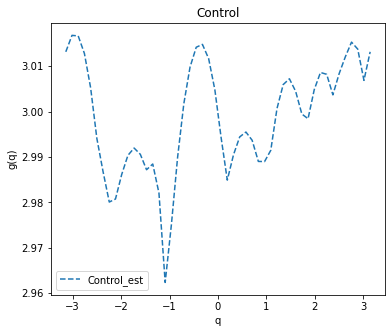

In [75]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
x1, x2 = torch.meshgrid(x, x)  # (cos q, sin q)

Control = 1. * 10 * torch.ones_like(x)

C_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    C_est[i] = test_model.defunc.m.controlNet(q.view(1, -1)).detach().cpu()

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), C_est, '--', label='Control_est')
# ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("g(q)")
ax.set_title("Control")
None

In [76]:
test_model = models[1]

In [88]:
for test in list(test_model.defunc.m.parameters()):
    print(test)

Parameter containing:
tensor([[ 1.1799e-01, -1.9661e-01, -3.0748e-01],
        [-1.0688e-01,  6.3155e-02, -1.9314e-03],
        [ 4.0064e-02, -2.8363e-02, -3.0653e-02],
        [ 1.6215e-01,  8.5230e-03, -4.1690e-03],
        [ 9.1893e-02,  2.9704e-02, -2.9992e-01],
        [ 1.5045e-01,  5.2737e-03,  1.1364e-01],
        [ 2.0938e-01,  1.2054e-01,  2.2549e-01],
        [-1.3516e-01, -1.5143e-01, -6.6758e-02],
        [ 3.0298e-02,  9.6959e-03, -6.7406e-02],
        [ 1.5305e-01,  5.3337e-02, -4.7660e-02],
        [-7.1401e-02, -9.9904e-02,  2.8832e-02],
        [-1.0749e-02, -4.7302e-02, -7.7656e-02],
        [-2.6327e-01,  9.3274e-02, -1.1017e-01],
        [-1.5676e-01,  9.9925e-02, -6.8615e-02],
        [ 1.1003e-01,  1.5568e-01, -1.7593e-03],
        [ 2.2558e-02, -1.3782e-03, -1.3616e-01],
        [ 1.1256e-01, -1.0073e-01,  2.6794e-02],
        [-6.3802e-02, -2.7269e-01, -7.0693e-02],
        [-1.1399e-01, -7.8443e-03,  1.3609e-01],
        [-4.9330e-02,  4.3145e-02,  6.9857e-02]